In [12]:
# 集成学习(ensemble learning)库
from autogluon.tabular import TabularPredictor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

集成学习主要有下面几种

Bootstrap聚合（Bagging）：它使集成模型中的每个模型在投票时具有相同的权重。它通过对不同的子数据集进行训练，然后对结果进行平均或投票，来降低模型的方差。随机森林就是一种基于Bagging的集成方法。

Boosting：它通过在训练新模型实例时更注重先前模型错误分类的实例来增量构建集成模型。它通过对每个模型赋予不同的权重，然后对结果进行加权平均或投票，来降低模型的偏差。AdaBoost和GBDT就是一些常用的Boosting方法。

Stacking：它是一种训练一个模型用于组合其他各个模型的方法。它首先在训练数据上训练多个不同的模型，然后把这些模型的输出作为输入来训练一个元模型，以得到一个最终的输出。

In [2]:
train_data = np.load("./highEnergy_trainData.npz")

label = "isgamma"

columns_need = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
]
columns_need.append(label)
train_data = {key: train_data[key] for key in columns_need}
for para in ["ne", "S50", "sumpf"]:
    train_data[para] = np.log10(train_data[para])
train_data = pd.DataFrame(train_data)

In [3]:
# predictor = TabularPredictor(
#     label=label,
#     path="./autogloun_model/highEnergy_Allcolumn",
#     eval_metric="roc_auc",
            # ).fit(train_data, num_cpus=40, num_gpus=2)
predictor = TabularPredictor.load("./autogloun_model/highEnergy_Allcolumn/")

In [4]:
test_data = np.load("./highEnergy_testData.npz")

test_data = {key: test_data[key] for key in columns_need}
for para in ["ne", "S50", "sumpf"]:
    test_data[para] = np.log10(test_data[para])
test_data = pd.DataFrame(test_data)

In [5]:
# 计算各种模型在测试集的得分
predictor.leaderboard(test_data)

                  model  score_test  score_val  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2    0.983645   0.984255       16.409919       0.667437   990.444420                 0.034898                0.003694           4.608511            2       True         14
1               XGBoost    0.983429   0.983864        4.488793       0.217294    24.624902                 4.488793                0.217294          24.624902            1       True         11
2            LightGBMXT    0.983320   0.983878       12.969266       0.849298   251.307740                12.969266                0.849298         251.307740            1       True          3
3         LightGBMLarge    0.983306   0.983700        8.899829       0.382890   190.838791                 8.899829                0.382890         190.838791            1       True         13
4        NeuralNetTorch    0.9

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.983645,0.984255,16.409919,0.667437,990.444420,0.034898,0.003694,4.608511,2,True,14
1,XGBoost,0.983429,0.983864,4.488793,0.217294,24.624902,4.488793,0.217294,24.624902,1,True,11
2,LightGBMXT,0.983320,0.983878,12.969266,0.849298,251.307740,12.969266,0.849298,251.307740,1,True,3
3,LightGBMLarge,0.983306,0.983700,8.899829,0.382890,190.838791,8.899829,0.382890,190.838791,1,True,13
4,NeuralNetTorch,0.983149,0.983929,2.986399,0.063559,770.372215,2.986399,0.063559,770.372215,1,True,12
5,LightGBM,0.982655,0.983271,1.295515,0.092256,39.557497,1.295515,0.092256,39.557497,1,True,4
6,CatBoost,0.982510,0.983088,0.261595,0.031116,37.827871,0.261595,0.031116,37.827871,1,True,7
7,RandomForestEntr,0.980875,0.981709,2.251791,0.149654,187.930765,2.251791,0.149654,187.930765,1,True,6
8,RandomForestGini,0.980326,0.981148,2.588068,0.151900,163.929022,2.588068,0.151900,163.929022,1,True,5
9,ExtraTreesEntr,0.977692,0.978773,2.222655,0.156579,104.885832,2.222655,0.156579,104.885832,1,True,9


In [6]:
# 计算特征重要性
predictor.feature_importance(test_data, subsample_size=int(1e5))

,importance,stddev,p_value,n,p99_high,p99_low
summd,0.446736,0.000993,2.929727e-12,5,0.448781,0.444692
nch,0.194930,0.000664,1.615692e-11,5,0.196297,0.193562
S50,0.066619,0.000571,6.491420e-10,5,0.067795,0.065442
sumpf,0.036919,0.000546,5.739754e-09,5,0.038043,0.035794
cy,0.017223,0.000465,6.369976e-08,5,0.018181,0.016266
cx,0.015451,0.000212,4.246667e-09,5,0.015888,0.015015
ne,0.012904,0.000110,6.258882e-10,5,0.013130,0.012678
sigma,0.006134,0.000148,4.114343e-08,5,0.006440,0.005829
theta,0.004724,0.000054,2.095892e-09,5,0.004836,0.004612
mr1,0.002958,0.000042,4.851660e-09,5,0.003044,0.002872


In [8]:
# 第二轮训练减少使用的参量
label = "isgamma"

columns_need = [
    "nch",
    "theta",
    #     "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    #     "age",
    "S50",
]
columns_need.append(label)
# predictor = TabularPredictor(
#     label=label,
#     path="./autogloun_model/highEnergy_fewcolumn",
#     eval_metric="roc_auc",
# ).fit(train_data[columns_need], num_cpus=40, num_gpus=2)
predictor = TabularPredictor.load("./autogloun_model/highEnergy_fewcolumn/")

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogloun_model/highEnergy_fewcolumn/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.179-1 (2023-05-12)
Train Data Rows:    3319007
Train Data Columns: 10
Label Column: isgamma
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to prepr

[1000]	valid_set's binary_logloss: 0.160829
[2000]	valid_set's binary_logloss: 0.157734
[3000]	valid_set's binary_logloss: 0.156667
[4000]	valid_set's binary_logloss: 0.156132
[5000]	valid_set's binary_logloss: 0.155726
[6000]	valid_set's binary_logloss: 0.155416
[7000]	valid_set's binary_logloss: 0.15518
[8000]	valid_set's binary_logloss: 0.155014
[9000]	valid_set's binary_logloss: 0.154867
[10000]	valid_set's binary_logloss: 0.154731


	0.9838	 = Validation score   (roc_auc)
	297.22s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.157231


	0.9833	 = Validation score   (roc_auc)
	48.11s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9814	 = Validation score   (roc_auc)
	155.22s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9819	 = Validation score   (roc_auc)
	181.13s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	0.9831	 = Validation score   (roc_auc)
	36.09s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9797	 = Validation score   (roc_auc)
	98.64s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9799	 = Validation score   (roc_auc)
	95.62s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9597	 = Validation score   (roc_auc)
	1024.34s	 = Training   runtime
	0.14s	 = Validation ru

[1000]	valid_set's binary_logloss: 0.155528
[2000]	valid_set's binary_logloss: 0.154619
[3000]	valid_set's binary_logloss: 0.154351
[4000]	valid_set's binary_logloss: 0.154262


	0.9838	 = Validation score   (roc_auc)
	156.38s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.9843	 = Validation score   (roc_auc)
	4.64s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3247.97s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogloun_model/highEnergy_fewcolumn/")


In [9]:
predictor.feature_importance(test_data)

These features in provided data are not utilized by the predictor and will be ignored: ['phi', 'age']
Computing feature importance via permutation shuffling for 10 features using 5000 rows with 5 shuffle sets...
	64.81s	= Expected runtime (12.96s per shuffle set)
	11.02s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
summd,0.447024,0.003708,5.681676e-10,5,0.454659,0.439388
nch,0.199795,0.004729,3.763930e-08,5,0.209532,0.190058
S50,0.118094,0.005449,5.422697e-07,5,0.129313,0.106875
sumpf,0.040150,0.002492,1.770810e-06,5,0.045280,0.035019
cy,0.016445,0.001247,3.930841e-06,5,0.019012,0.013879
cx,0.014110,0.001171,5.631458e-06,5,0.016520,0.011700
ne,0.008402,0.000900,1.555095e-05,5,0.010254,0.006549
sigma,0.006707,0.000402,1.547711e-06,5,0.007536,0.005879
theta,0.004169,0.000562,3.868845e-05,5,0.005326,0.003012
mr1,0.003167,0.000244,4.212528e-06,5,0.003670,0.002664


In [11]:
test_data["prob"] = predictor.predict_proba(test_data)[1]

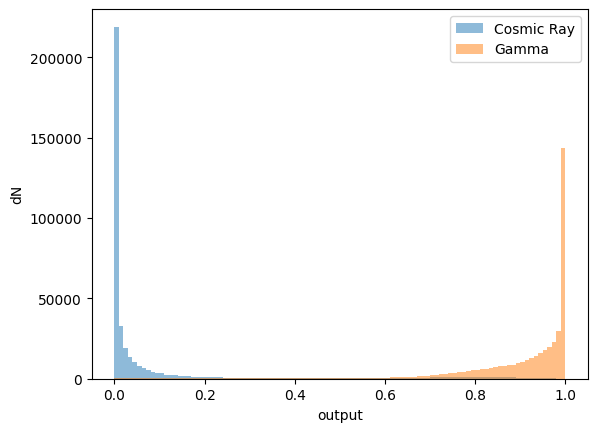

In [19]:
# 查看一下分布
plt.hist(
    test_data["prob"][test_data["isgamma"] == 0],
    bins=np.linspace(0, 1, 101),
    alpha=0.5,
    label="Cosmic Ray",
)
plt.hist(
    test_data["prob"][test_data["isgamma"] == 1],
    bins=np.linspace(0, 1, 101),
    alpha=0.5,
    label="Gamma",
)
plt.xlabel("output")
plt.ylabel("dN")
plt.legend()
plt.show()

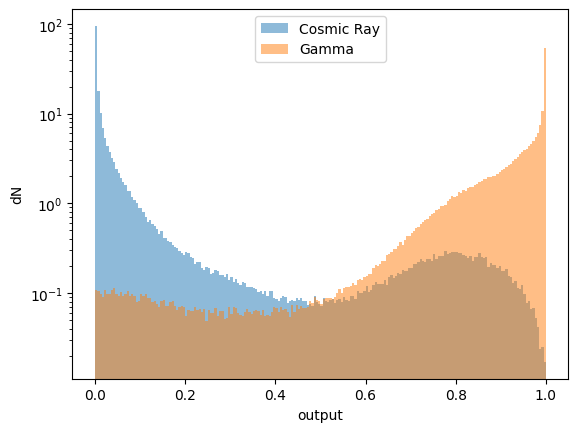

In [58]:
# 查看一下分布
plt.hist(
    test_data["prob"][test_data["isgamma"] == 0],
    bins=np.linspace(0, 1, 201),
    alpha=0.5,
    label="Cosmic Ray",
    density=True,
)
plt.hist(
    test_data["prob"][test_data["isgamma"] == 1],
    bins=np.linspace(0, 1, 201),
    alpha=0.5,
    label="Gamma",
    density=True,
)
plt.legend()
plt.yscale("log")
plt.xlabel("output")
plt.ylabel("dN")
plt.show()

### 查看不同sumpf的分类好坏

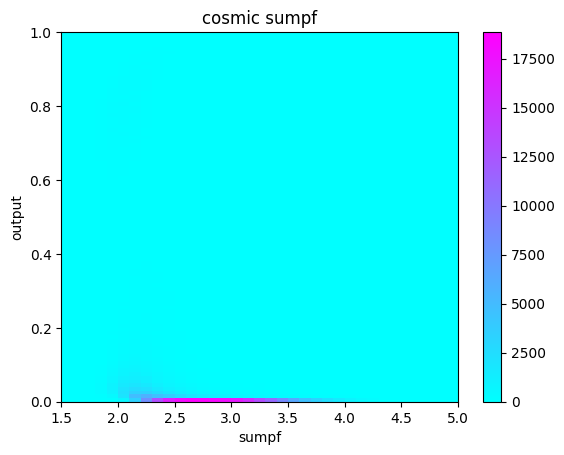

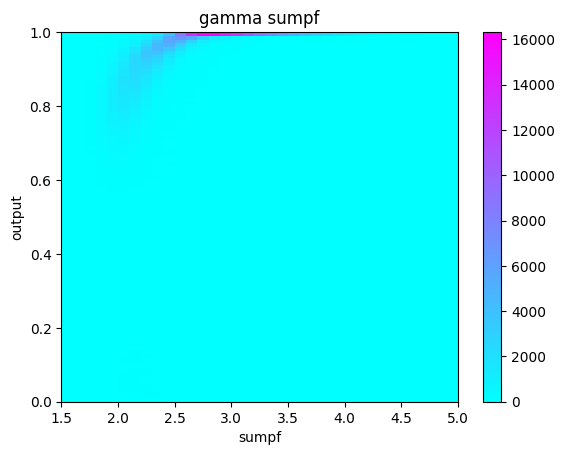

In [56]:
# sumpf
para = "sumpf"
xbins = np.linspace(1.5, 5, 36)
ybins = np.linspace(0, 1, 101)
H_cosmic, _, _ = np.histogram2d(
    test_data[para][test_data["isgamma"] == 0],
    test_data["prob"][test_data["isgamma"] == 0],
    bins=(xbins, ybins),
)
H_gamma, _, _ = np.histogram2d(
    test_data[para][test_data["isgamma"] == 1],
    test_data["prob"][test_data["isgamma"] == 1],
    bins=(xbins, ybins),
)
H_cosmic = H_cosmic.T
H_gamma = H_gamma.T
c = plt.pcolormesh(xbins, ybins, H_cosmic, cmap="cool")
plt.colorbar(c)
plt.ylabel("output")
plt.xlabel(para)
plt.title(f"cosmic {para}")
plt.show()
c = plt.pcolormesh(xbins, ybins, H_gamma, cmap="cool")
plt.colorbar(c)
plt.ylabel("output")
plt.xlabel(para)
plt.title(f"gamma {para}")
plt.show()